## Import Library

In [2]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from scipy.stats import randint
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

## Load dataset

In [3]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


the data type of totalcharges should be numerical not an object

In [5]:
# exclude row with TotalCharges column contains white space
df = df.loc[~df['TotalCharges'].str.contains(' ')]

# transform TotalCharges col to float
df['TotalCharges'] = df['TotalCharges'].astype(float)

### Check missing value

In [6]:
df.columns[df.isnull().any()]

Index([], dtype='object')

### Check duplicate value

In [7]:
df.duplicated().sum()

0

In [8]:
#Check duplicate value with ID table
df.duplicated(subset='customerID').sum()

0

## EDA

In [9]:
value_mapping = {
    'No': 0,
    'Yes' : 1
}
df['Churn_Num'] = df['Churn'].map(value_mapping)
df[['Churn_Num']]

,Churn_Num
0,0
1,0
2,1
3,0
4,1
...,...
7038,0
7039,0
7040,0
7041,1


In [10]:
numerical = []
categorical = []
for i in df.columns:
    if (df[i].dtypes == 'float64') or (df[i].dtypes == 'int64'):
        numerical.append(i)
    elif (df[i].dtypes != 'float64') and (df[i].dtypes != 'int64'):
        categorical.append(i)
print(numerical)
print(categorical)

['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'Churn_Num']
['customerID', 'gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn']


In [11]:
df[numerical].describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn_Num
count,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000
mean,0.162400,32.421786,64.798208,2283.300441,0.265785
std,0.368844,24.545260,30.085974,2266.771362,0.441782
min,0.000000,1.000000,18.250000,18.800000,0.000000
25%,0.000000,9.000000,35.587500,401.450000,0.000000
50%,0.000000,29.000000,70.350000,1397.475000,0.000000
75%,0.000000,55.000000,89.862500,3794.737500,1.000000
max,1.000000,72.000000,118.750000,8684.800000,1.000000


In [12]:
df[categorical].describe()

,customerID,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn
count,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032
unique,7032,2,2,2,2,3,3,3,3,3,3,3,3,3,2,4,2
top,7590-VHVEG,Male,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,No
freq,1,3549,3639,4933,6352,3385,3096,3497,3087,3094,3472,2809,2781,3875,4168,2365,5163


most of column categorical have two or three categorik, and two colums have more than three categorik. There are customerID (just ignored) and PaymentMethod

### Distribution data

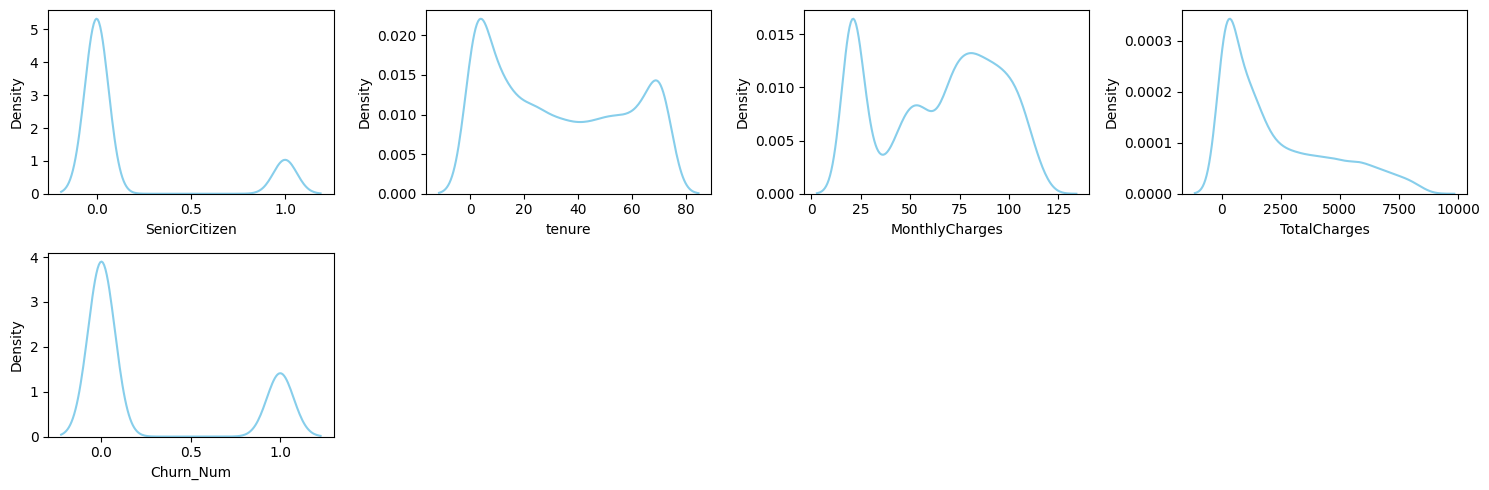

In [13]:
# adjust the figure size for better readability
plt.figure(figsize=(15,5))

features = numerical
for i in range(0, len(features)):
    plt.subplot(2, len(features)//2 + 2, i+1)
    sns.kdeplot(x=df[features[i]], color='skyblue')
    plt.xlabel(features[i])
    plt.tight_layout()

* customers has 2 group distribution of tenure, there are 1-2 month and around 70 month
* there are two group distribution of monthly charges, there take cheap monthly charges and expensive monthly charges
* most customers have less than 2000 total charges
* there is an imbalance in the data of senior citizen
* there is an imbalance in the data of customer churn

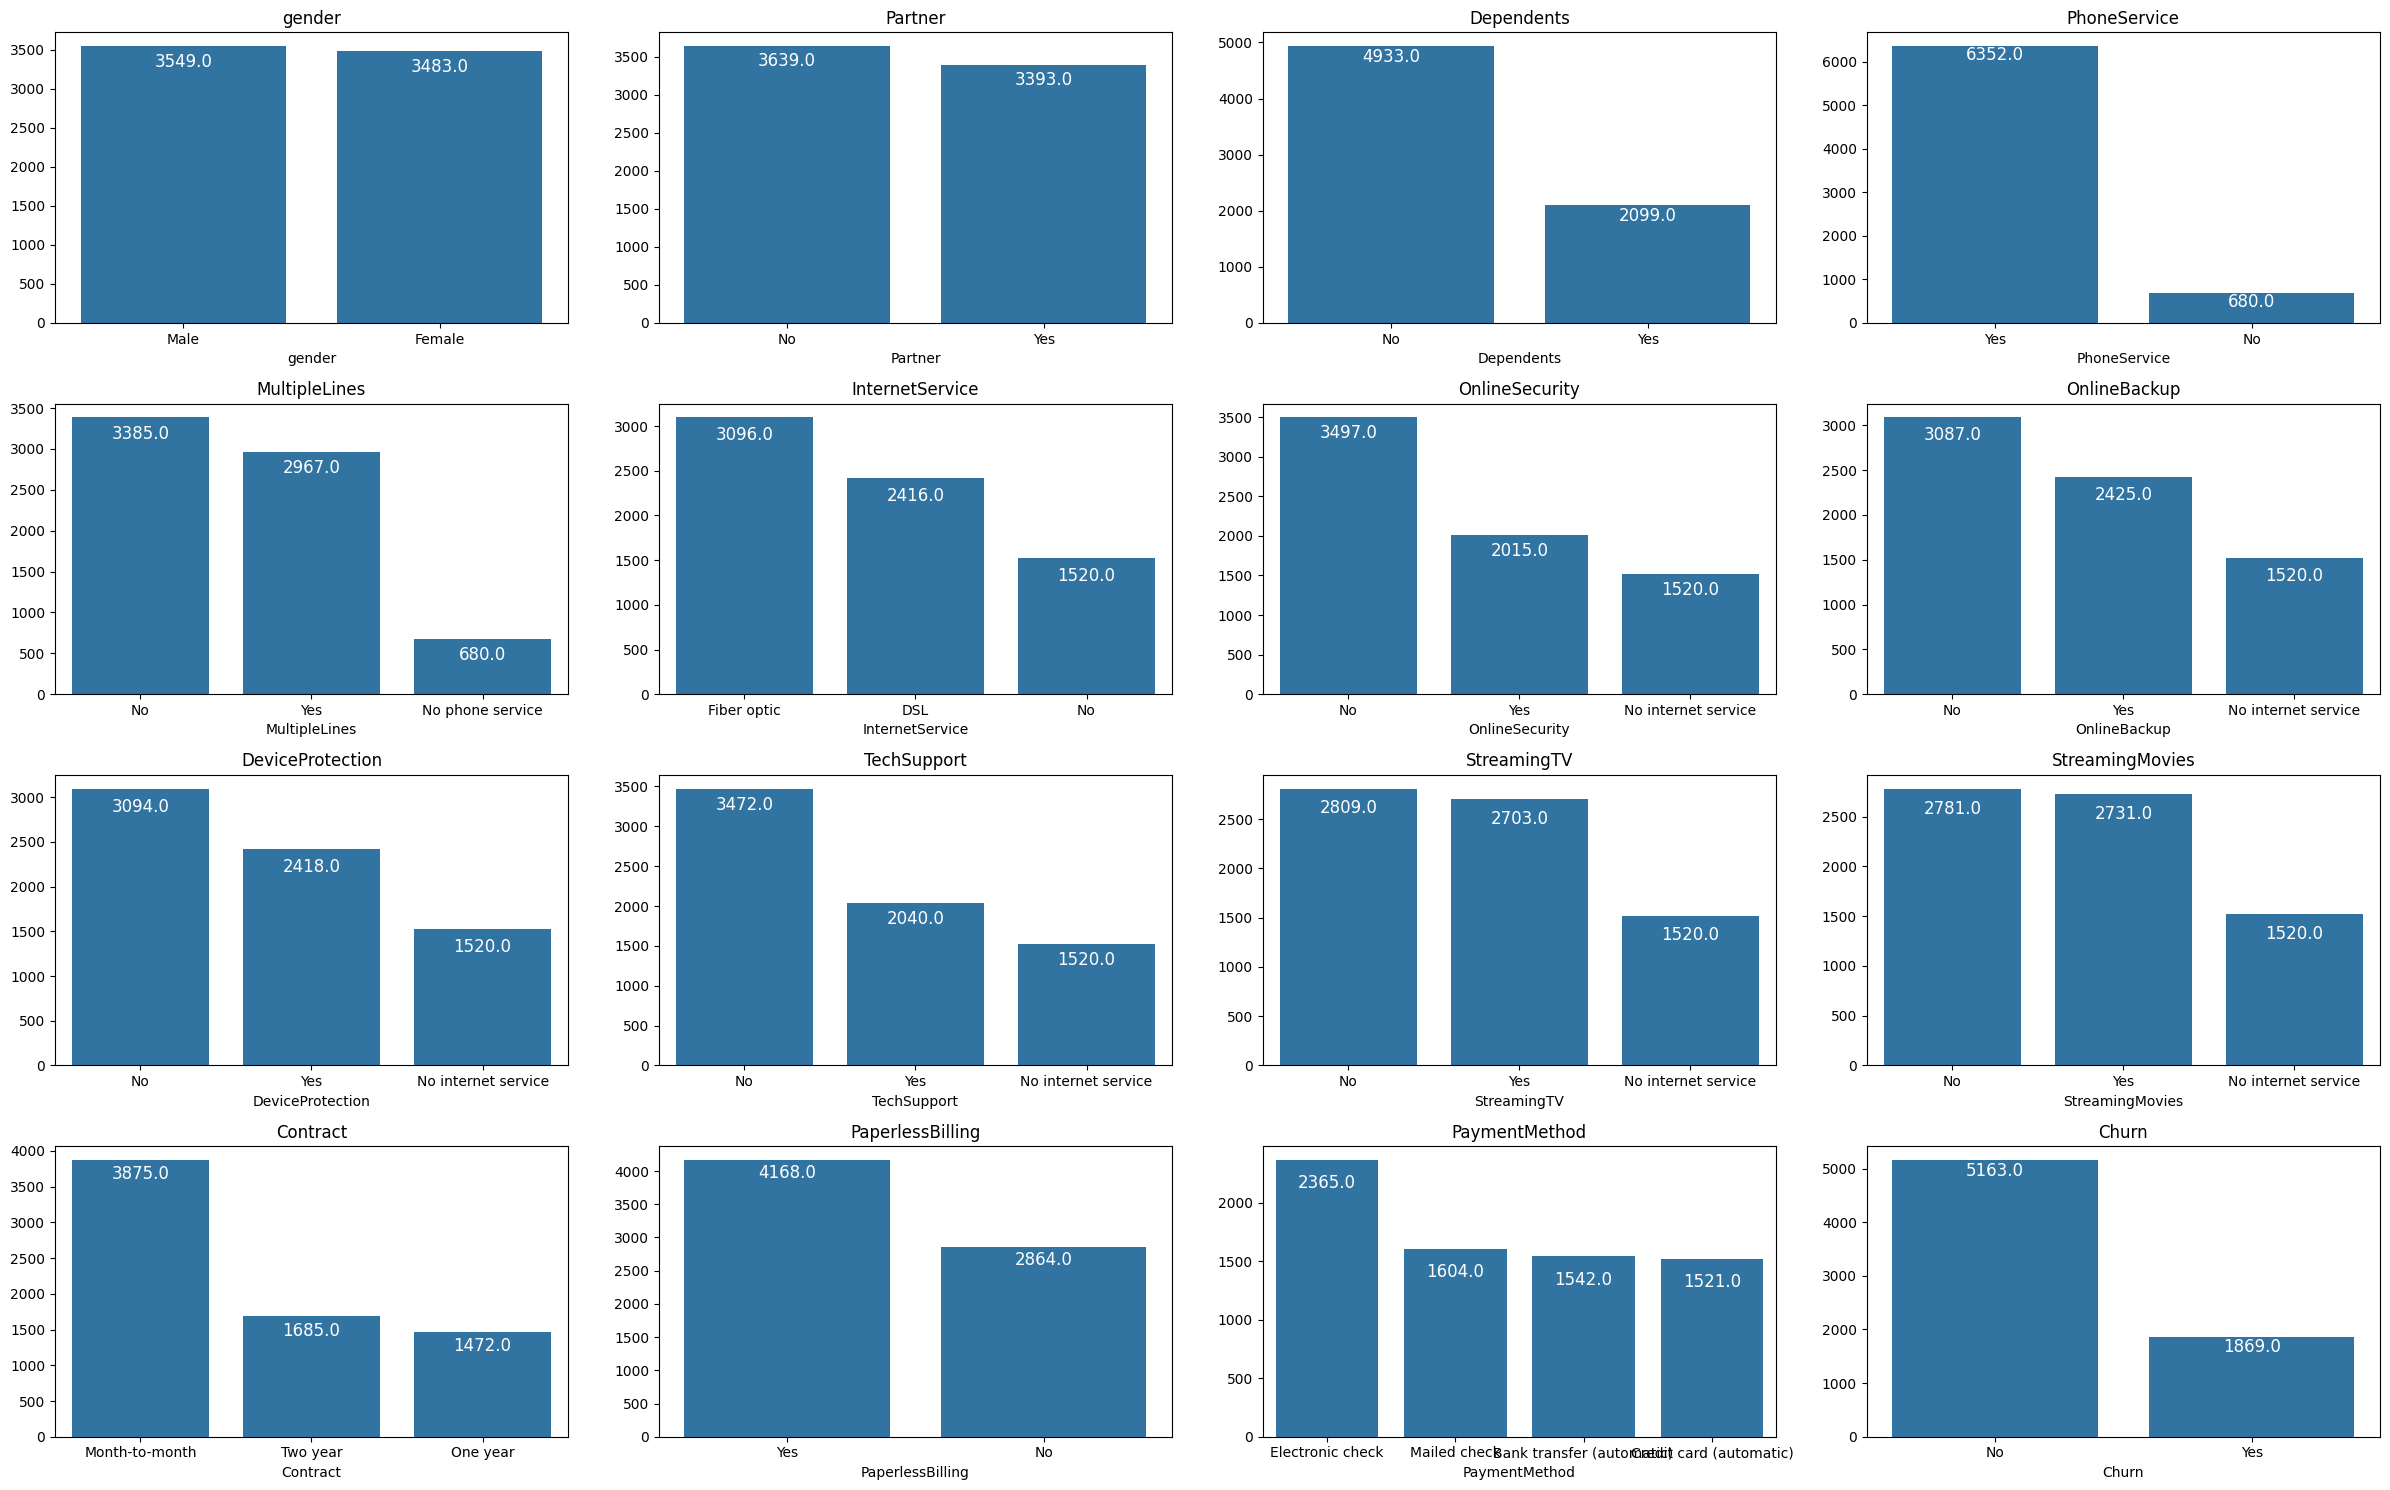

In [14]:
# plotting
categorical.remove('customerID')
jumlah_kategori = len(categorical)
baris = jumlah_kategori//4
kolom = 4

# Membuat subplot dengan ukuran baris x kolom
fig, axes = plt.subplots(baris, kolom, figsize=(24, 15))

# Loop melalui setiap kolom
for i, ax in enumerate(axes.flat):
    if i < jumlah_kategori:
        sns.barplot(x=df[categorical[i]].value_counts().index, y=df[categorical[i]].value_counts().values, ax=ax)
        for p in ax.patches:
            width, height = p.get_width(), p.get_height()
            x, y = p.get_xy()
            ax.annotate(f'{height}', (x + width / 2, y + height - 200), ha='center', va='center', fontsize=12, color='white')
        ax.set_title(categorical[i])

plt.tight_layout()
plt.show()

* the number of categorical features with balanced distribution is less than unbalanced.
* Categorical features that are relatively balanced include: gender, partner, streaming movies, streaming tv, payment method.

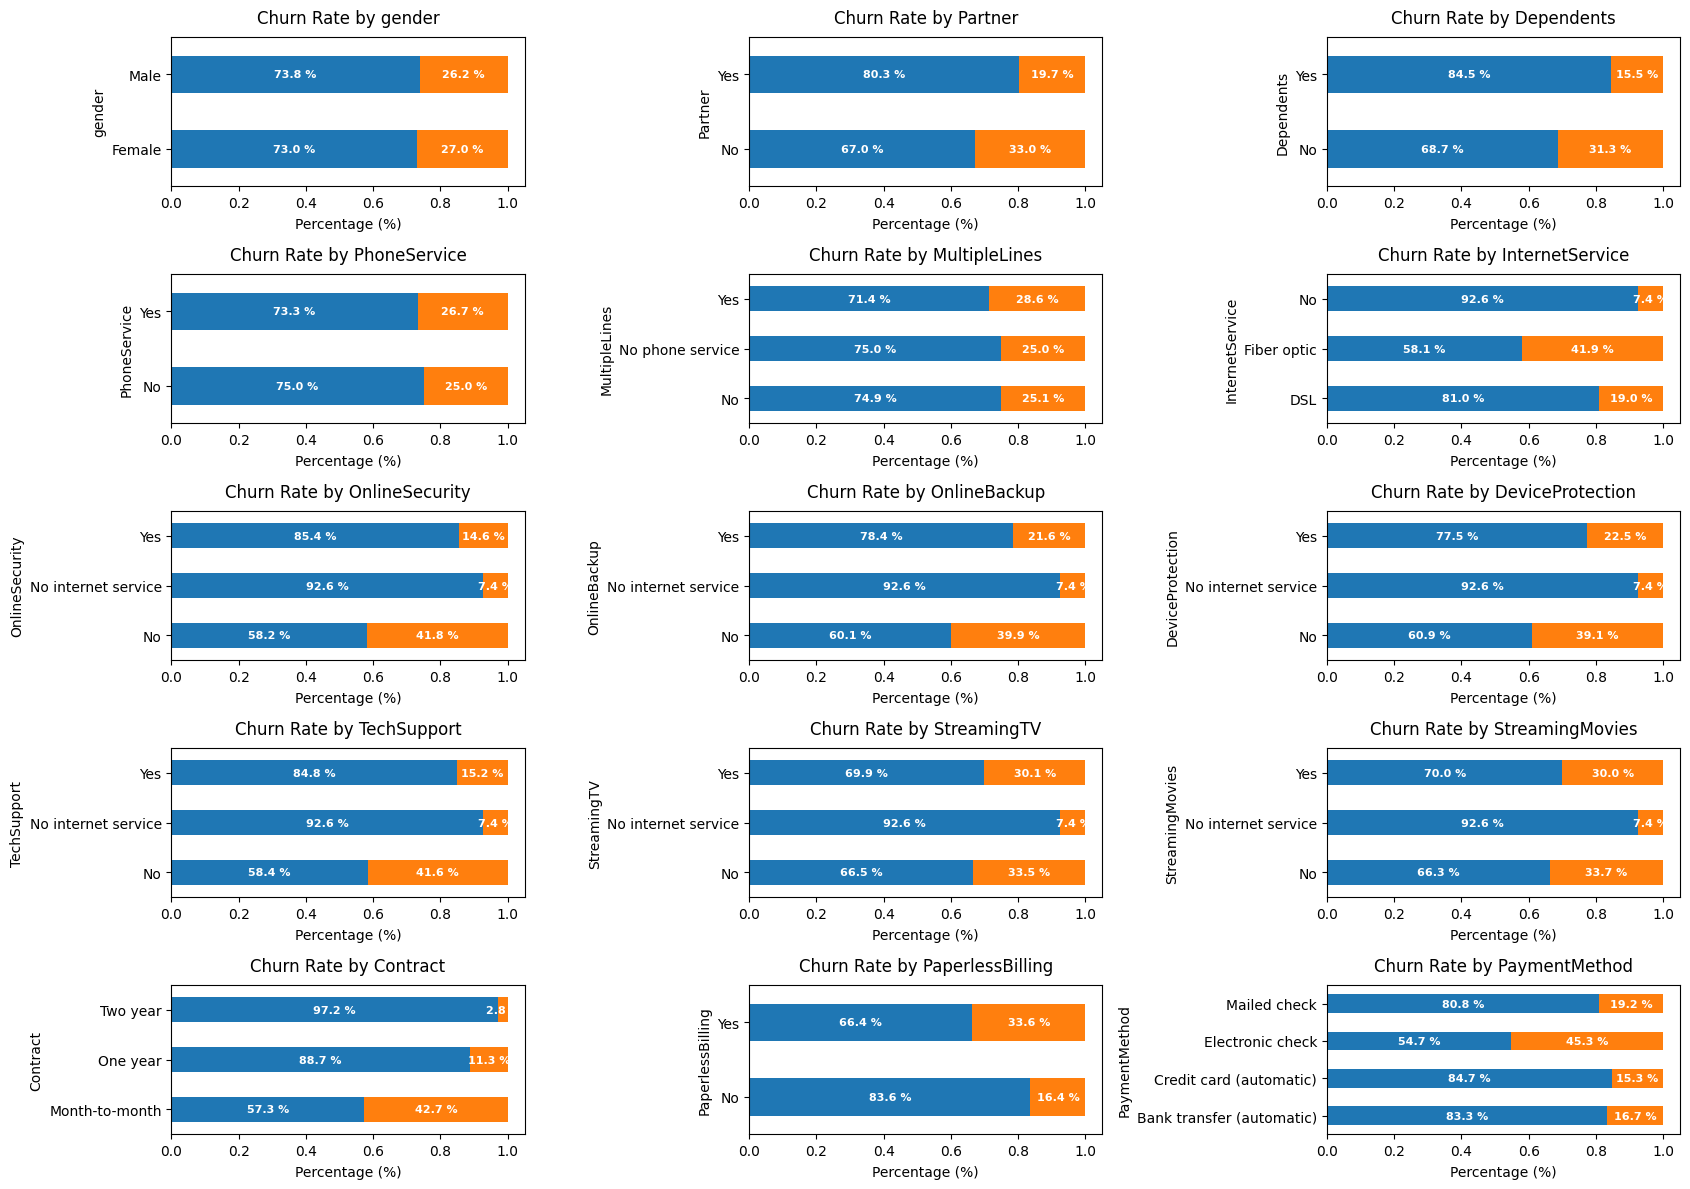

In [15]:
columns_to_plot = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']

# Mendeklarasikan subplot dengan objek sumbu matplotlib
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(17, 12))

for i, column in enumerate(columns_to_plot):
    # Menghitung proporsi dan melakukan plotting
    ax = pd.crosstab(df[column], df['Churn'], normalize='index').plot.barh(stacked=True, ax = axes[i // 3, i % 3])
    ax.legend(bbox_to_anchor=(0.5, 0.5), title='Is Churn', fontsize=10, title_fontsize=10, labels=['No', 'Yes'], loc='lower left')
    ax.legend().remove()

    # Menambahkan label persentase
    j = 1
    for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy() 
        ax.text(x+width/2, y+height/2, '{:.1f} %'.format(width*100),  # Perhatikan perubahan di sini
                horizontalalignment='center', verticalalignment='center',
                color='white', fontsize=8, weight='bold')
        j += 1

    # Menambahkan judul dan label sumbu
    ax.set_title(f'Churn Rate by {column}', fontsize=12, pad=10)
    ax.set_xlabel('Percentage (%)', fontsize=10, labelpad=5)  # Perhatikan perubahan di sini
    ax.set_ylabel(column, fontsize=10)

# Menyusun tata letak subplot
plt.tight_layout()
plt.show()

* Customers who take annual contracts are less likely to churn.
* Customers without have techsupport, device support, online backup, online security, device protection have a higher churn potential than customers who have it.
* By payment method, customers with electronic checks potentially get a higher churn rate than customers with other methods.
* Customers who are not dependent have a higher churn rate than dependent customers.
* Customers who do not have partner have a higher churn rate than customer who do
* Customers who take Internet service fiber optic have a higher churn rate

Create new collumn 'support_and_security' contains customers  do not take OnlineSecurity, OnlineBackup, TechSupport, and DeviceProtection services at the same time

In [16]:
condition_1 = df['OnlineSecurity'] == 'No'
condition_2 = df['OnlineBackup'] == 'No'
condition_3 = df['TechSupport'] == 'No'
condition_4 = df['DeviceProtection'] == 'No'

df['support_and_security'] = np.where((condition_1) & (condition_2) & (condition_3) & (condition_4), 'No', 'Yes')
df['support_and_security'].head(5)

0    Yes
1    Yes
2    Yes
3    Yes
4     No
Name: support_and_security, dtype: object

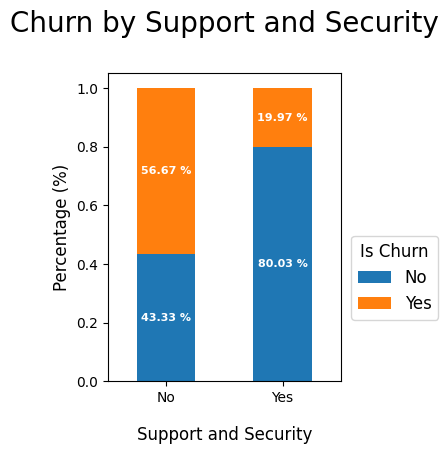

In [17]:
deposit_ax = pd.crosstab(df['support_and_security'], df['Churn'], normalize = 'index').plot.bar(stacked=True, figsize=(3,4))
plt.legend(bbox_to_anchor=(1.01, 0.5), title='Is Churn', fontsize=12, title_fontsize=12, labels=['No','Yes'])

j = 1    
for p in deposit_ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    deposit_ax.text(x+width/2, 
            y+height/2, 
            '{:.2f} %'.format(height*100), 
            horizontalalignment='center', 
            verticalalignment='center',
            color='white', fontsize=8, weight='bold')
    j += 1
    
plt.title('Churn by Support and Security', fontsize=20, pad=30)  
plt.xticks(rotation=360)  
plt.xlabel('Support and Security', fontsize=12, labelpad=15)
plt.ylabel('Percentage (%)', fontsize=12)
plt.show()

* It looks that customers without the support and security in their packet have a high potential to churn

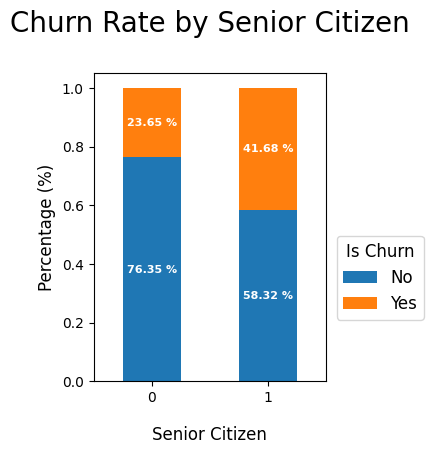

In [18]:
senior_ax = pd.crosstab(df['SeniorCitizen'], df['Churn'], normalize = 'index').plot.bar(stacked=True, figsize=(3,4))
plt.legend(bbox_to_anchor=(1.01, 0.5), title='Is Churn', fontsize=12, title_fontsize=12, labels=['No','Yes'])

j = 1    
for p in senior_ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    senior_ax.text(x+width/2, 
            y+height/2, 
            '{:.2f} %'.format(height*100), 
            horizontalalignment='center', 
            verticalalignment='center',
            color='white', fontsize=8, weight='bold')
    j += 1
    
plt.title('Churn Rate by Senior Citizen', fontsize=20, pad=30)  
plt.xticks(rotation=360)  
plt.xlabel('Senior Citizen', fontsize=12, labelpad=15)
plt.ylabel('Percentage (%)', fontsize=12)
plt.show()

* It looks that senior citizen have a high potential to churn

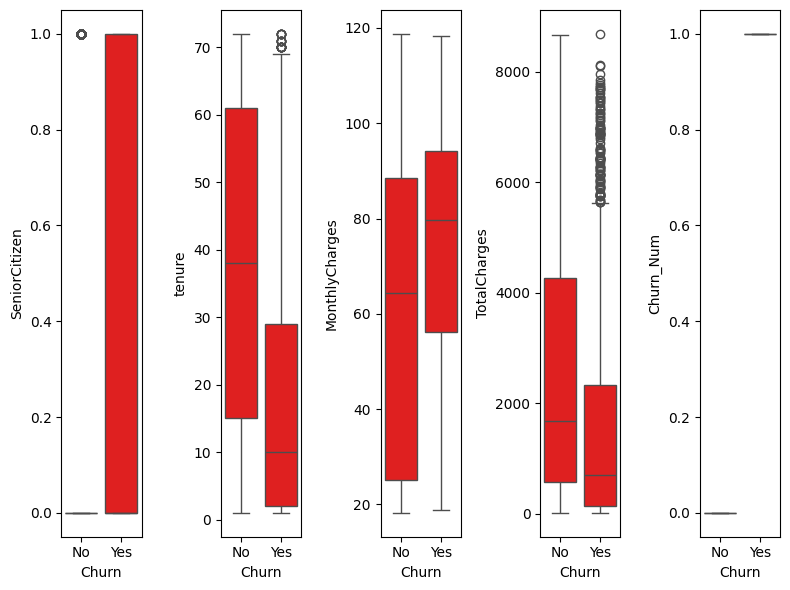

In [19]:
# numerical.remove('Churn_Num')
plt.figure(figsize=(8,6))

features = numerical
for i in range(0, len(features)):
    plt.subplot(1, len(features), i+1)
    sns.boxplot(x = df['Churn'], y=df[features[i]], color='red')
    plt.tight_layout()

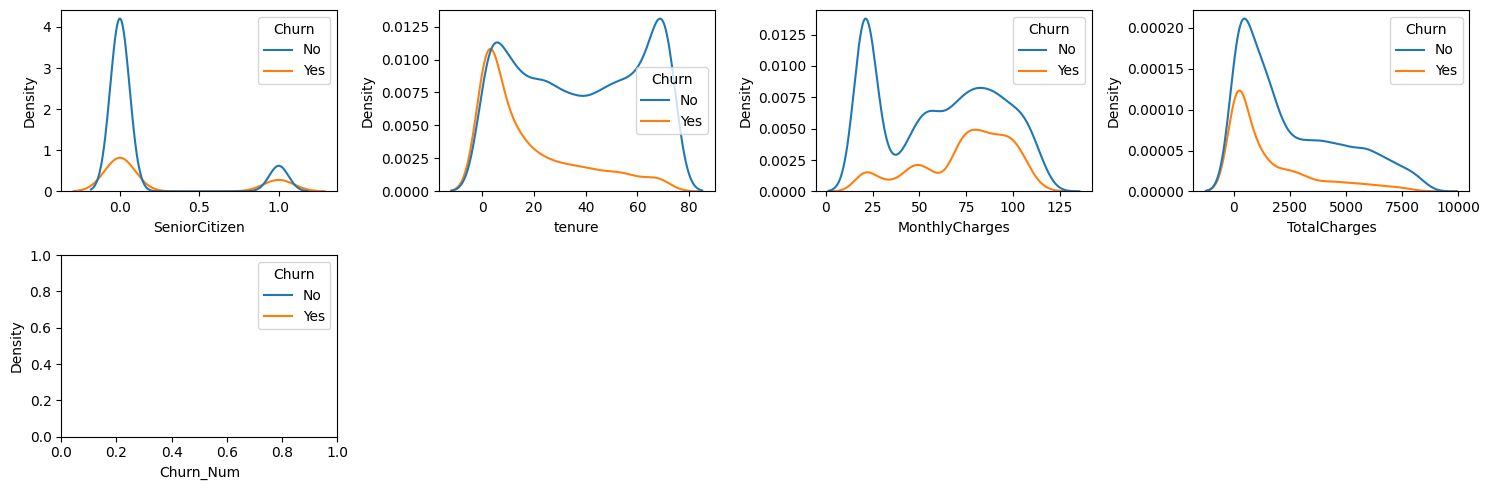

In [20]:
# adjust the figure size for better readability
plt.figure(figsize=(15,5))

features = numerical
for i in range(0, len(features)):
    plt.subplot(2, len(features)//2 + 2, i+1)
    sns.kdeplot(x=df[features[i]], color='skyblue', hue=df['Churn'])
    plt.xlabel(features[i])
    plt.tight_layout()

* from boxplot and displot, It is known that people churn mostly has low tenure than people not churn
* from boxplot we can see that people churn has low total charges than people not churn
* from boxplot value Q1, Q2 and Q3 customer churn > Q1, Q2, and Q3 customer not churn

from data exploratory retrieved feature use to predict people churn are:\
Partner, Dependents, tenure, InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, Contract,
PaperlessBilling, PaymentMethod, TotalCharges, SeniorCitizen, support_and_security, MonthlyCharges, support_and_security

## Feature Encoding

In [21]:
df1 = df[['Partner', 'Dependents', 'tenure', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
          'DeviceProtection', 'TechSupport', 'Contract', 'PaperlessBilling', 'PaymentMethod',
          'TotalCharges', 'Churn_Num', 'SeniorCitizen', 'support_and_security', 'MonthlyCharges']]

In [22]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Partner               7032 non-null   object 
 1   Dependents            7032 non-null   object 
 2   tenure                7032 non-null   int64  
 3   InternetService       7032 non-null   object 
 4   OnlineSecurity        7032 non-null   object 
 5   OnlineBackup          7032 non-null   object 
 6   DeviceProtection      7032 non-null   object 
 7   TechSupport           7032 non-null   object 
 8   Contract              7032 non-null   object 
 9   PaperlessBilling      7032 non-null   object 
 10  PaymentMethod         7032 non-null   object 
 11  TotalCharges          7032 non-null   float64
 12  Churn_Num             7032 non-null   int64  
 13  SeniorCitizen         7032 non-null   int64  
 14  support_and_security  7032 non-null   object 
 15  MonthlyCharges        7032

### Encoding Categorical Feature

Feature with 2 categories will encode with label encoding:
Partner, Dependents, PaperlessBilling, support_and_security

In [23]:
from sklearn import preprocessing
partner = preprocessing.LabelEncoder()
partner.fit(df1['Partner'])
df1['Partner'] = partner.transform(df1['Partner'])

In [24]:
dependent = preprocessing.LabelEncoder()
dependent.fit(df1['Dependents'])
df1['Dependents'] = dependent.transform(df1['Dependents'])

In [25]:
paperlessbilling = preprocessing.LabelEncoder()
paperlessbilling.fit(df1['PaperlessBilling'])
df1['PaperlessBilling'] = dependent.transform(df1['PaperlessBilling'])

In [26]:
sas = preprocessing.LabelEncoder()
sas.fit(df1['support_and_security'])
df1['support_and_security'] = sas.transform(df1['support_and_security'])

In [27]:
df1.sample(3)

,Partner,Dependents,tenure,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,Contract,PaperlessBilling,PaymentMethod,TotalCharges,Churn_Num,SeniorCitizen,support_and_security,MonthlyCharges
2170,0,0,21,DSL,Yes,No,Yes,Yes,One year,1,Electronic check,1258.35,0,0,1,60.25
2120,1,1,55,No,No internet service,No internet service,No internet service,No internet service,Two year,0,Mailed check,1210.30,0,0,1,21.00
1877,0,0,72,DSL,Yes,Yes,Yes,Yes,Two year,0,Credit card (automatic),6362.35,0,0,1,88.55


Feature more than 2 categories will encode with one hot encoding:
InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, Contract, PaymentMethod

In [28]:
columns_to_encode = ['InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'Contract', 'PaymentMethod']
df_encoded = pd.get_dummies(df1, columns=columns_to_encode)
df1 = pd.concat([df1.drop(columns=columns_to_encode), df_encoded], axis=1)
duplicate_columns = df1.columns[df1.columns.duplicated()]
df1 = df1.loc[:, ~df1.columns.duplicated()]

In [29]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 31 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Partner                                  7032 non-null   int32  
 1   Dependents                               7032 non-null   int32  
 2   tenure                                   7032 non-null   int64  
 3   PaperlessBilling                         7032 non-null   int32  
 4   TotalCharges                             7032 non-null   float64
 5   Churn_Num                                7032 non-null   int64  
 6   SeniorCitizen                            7032 non-null   int64  
 7   support_and_security                     7032 non-null   int32  
 8   MonthlyCharges                           7032 non-null   float64
 9   InternetService_DSL                      7032 non-null   bool   
 10  InternetService_Fiber optic              7032 non-nul

### Imbalanced Handling

In [30]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [31]:
X = df1.drop(columns='Churn_Num', axis=1)
y = df1['Churn_Num']
X.shape, y.shape

((7032, 30), (7032,))

In [32]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [125]:
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

def sampler_compare(samplers, X_train, y_train, X_test, y_test):
    accus, accu_balanceds = [], []

    for sampler in samplers.values():
        X_train_balanced, y_train_balanced = sampler.fit_resample(X_train, y_train)
        
        # Test by logistic regression accuracy
        tree = DecisionTreeClassifier()
        clf = tree.fit(X_train, y_train)
        accu = roc_auc_score(y_test, clf.predict(X_test))
        clf_balanced = tree.fit(X_train_balanced, y_train_balanced)
        accu_balanced = roc_auc_score(y_test, clf_balanced.predict(X_test))

        accus.append(accu)
        accu_balanceds.append(accu_balanced)

    return accus, accu_balanceds


samplers = {'Undersample': RandomUnderSampler(),
           'Oversample': RandomOverSampler(),
           'SMOTE': SMOTE()}

accus, accu_balanceds = np.round(sampler_compare(samplers, X_train, y_train, X_test, y_test), 4)

In [126]:
# Output comparsion table
table = pd.DataFrame({"Balancing Method": samplers.keys(), 
                      "Accuracy (imbalanced)": accus, 
                      "Accuracy (balanced)": accu_balanceds})

pd.pivot_table(table, index=['Balancing Method']).sort_values(by="Accuracy (balanced)", ascending=False)

,Accuracy (balanced),Accuracy (imbalanced)
Balancing Method,,
Undersample,0.6790,0.6567
SMOTE,0.6731,0.6597
Oversample,0.6594,0.6630


It looks like the resampling method (undersample) has a higher score in accuracy (AUC score) than without resampling.

In [33]:
X_train_balanced, y_train_balanced = RandomUnderSampler(random_state=42).fit_resample(X_train, y_train)
print(X_train_balanced.shape)
print(y_train_balanced.shape)

(2990, 30)
(2990,)


## Modelling

In [34]:
from sklearn.metrics import confusion_matrix, f1_score, recall_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

def create_models(models, X_train, X_test, y_train, y_test):
    get_model, f1_scores, recall_scores, auc_scores = [], [], [], []
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    for name, model in models.items():
        # Fit models
        if name == "XGBoost":
            X_train_np = X_train.to_numpy()
            y_train_np = y_train.to_numpy()
            clf = model.fit(X_train_np, y_train_np)
            y_prob = clf.predict_proba(X_test)[:, 1]
            y_pred = clf.predict(X_test) ; y_pred_train = clf.predict(X_train_np)
        else:
            clf = model.fit(X_train, y_train)
            y_prob = clf.predict_proba(X_test)[:, 1]
            y_pred = clf.predict(X_test) ; y_pred_train = clf.predict(X_train)
        # Evaluate metrics
        recall_model_result = round(recall_score(y_test, y_pred), 4); recall_train = round(recall_score(y_train, y_pred_train),4)
        f1 = round(f1_score(y_test, y_pred), 4); f1_train = round(f1_score(y_train, y_pred_train),4)
        auc = round(roc_auc_score(y_test, y_prob), 4);

        # Print Evaluation Metrics
        print("===================================================================================")
        print(f"Nama: {name}\nRecall Training: {recall_train}\nRecall Test: {recall_model_result}\nF1-Score Train: {f1_train}\nF1-Score Test: {f1}")
        print("===================================================================================")

        #Append values to list
        f1_scores.append(f1); auc_scores.append(auc)
        get_model.append(clf); recall_scores.append(recall_model_result)
    return get_model, f1_scores, recall_scores, auc_scores

def evaluate(models, f1_scores, recall_scores, auc_scores):
    table = pd.DataFrame({
        "Model": models.keys(),
        "AUC Score": auc_scores,
        "F1-Score": f1_scores,
        "Recall": recall_scores
    })
    result = table.set_index('Model').sort_values(by="Recall", ascending=False).reset_index()
    return result

Rationale for selecting the evaluation metrics used:
1. Recall: Recall measures the model's ability to identify all positive class instances. In the context of churn, this means identifying as many customers as possible who actually quit. High recall can help ensure that customers who quit are actually identified, allowing companies to take more effective and proactive retention actions.
2. AUC Score: The AUC Score provides an overall picture of the model's performance, not just at one particular point. It measures the model's ability to distinguish between positive and negative classes across various threshold levels. In churn prediction, where the balance between false positive rate (identifying customers who did not quit as quitters) and true positive rate (identifying customers who quit as quitters) is important, AUC Score provides a holistic picture of the model's capabilities.
3. F1-Score: F1-Score is a measure of the balance between precision and recall. A high F1-Score indicates a good balance between the model's ability to identify positive classes and avoid false positives. In the telecom industry, where the cost of retention and churn prevention efforts can be significant, having a good balance between retaining customers who quit and avoiding unnecessary efforts on customers who will not quit is important.

In [35]:
models = {'Logistic Regression': LogisticRegression(),
          'KNN Neighbors': KNeighborsClassifier(),
          'Decision Tree': DecisionTreeClassifier(),
          'Random Forest': RandomForestClassifier(),
          'XGBoost': XGBClassifier()}

In [36]:
get_model, f1_scores, recall_scores, auc_scores = create_models(models, X_train_balanced, X_test, y_train_balanced, y_test)
hasil1 = evaluate(models, f1_scores, recall_scores, auc_scores)
hasil1

Nama: Logistic Regression
Recall Training: 0.7987
Recall Test: 0.7834
F1-Score Train: 0.7766
F1-Score Test: 0.6098
Nama: KNN Neighbors
Recall Training: 0.806
Recall Test: 0.7139
F1-Score Train: 0.7967
F1-Score Test: 0.5592
Nama: Decision Tree
Recall Training: 0.996
Recall Test: 0.6658
F1-Score Train: 0.998
F1-Score Test: 0.5139
Nama: Random Forest
Recall Training: 0.9987
Recall Test: 0.754
F1-Score Train: 0.998
F1-Score Test: 0.5949
Nama: XGBoost
Recall Training: 0.9793
Recall Test: 0.7727
F1-Score Train: 0.9581
F1-Score Test: 0.5922


,Model,AUC Score,F1-Score,Recall
0,Logistic Regression,0.8276,0.6098,0.7834
1,XGBoost,0.8042,0.5922,0.7727
2,Random Forest,0.8093,0.5949,0.7540
3,KNN Neighbors,0.7574,0.5592,0.7139
4,Decision Tree,0.6660,0.5139,0.6658


* Based on the AUC Score, F1-score, and recall metrics, the best model is the logistic regression model.
* The other models seem to overfitting, as indicated by the high trains score but decreased when tested with test data.

### Try to feature scaling and create model again

In [37]:
from sklearn.preprocessing import Normalizer
numeric_features = ['tenure','TotalCharges','MonthlyCharges']
df2 = df1.copy()
scaler = Normalizer()
df2[numeric_features] = scaler.fit_transform(df2[numeric_features])

In [38]:
X = df2.drop(columns='Churn_Num', axis=1)
y = df2['Churn_Num']
X.shape, y.shape
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [39]:
X_train_balanced, y_train_balanced = RandomUnderSampler(random_state=42).fit_resample(X_train, y_train)
print(X_train_balanced.shape)
print(y_train_balanced.shape)

(2990, 30)
(2990,)


In [40]:
models = {'Logistic Regression_FS': LogisticRegression(),
          'KNN Neighbors_FS': KNeighborsClassifier(),
          'Decision Tree_FS': DecisionTreeClassifier(),
          'Random Forest_FS': RandomForestClassifier(),
          'XGBoost_FS': XGBClassifier()}

In [41]:
get_model_fs, f1_scores_fs, recall_scores_fs, auc_scores_fs, = create_models(models, X_train_balanced, X_test, y_train_balanced, y_test)
hasil2= evaluate(models, f1_scores_fs, recall_scores_fs, auc_scores_fs)
hasil2

Nama: Logistic Regression_FS
Recall Training: 0.8227
Recall Test: 0.7995
F1-Score Train: 0.7824
F1-Score Test: 0.601
Nama: KNN Neighbors_FS
Recall Training: 0.8234
Recall Test: 0.7406
F1-Score Train: 0.8115
F1-Score Test: 0.567
Nama: Decision Tree_FS
Recall Training: 0.996
Recall Test: 0.6738
F1-Score Train: 0.998
F1-Score Test: 0.5159
Nama: Random Forest_FS
Recall Training: 0.9993
Recall Test: 0.762
F1-Score Train: 0.998
F1-Score Test: 0.5981
Nama: XGBoost_FS
Recall Training: 0.988
Recall Test: 0.762
F1-Score Train: 0.9638
F1-Score Test: 0.5925


,Model,AUC Score,F1-Score,Recall
0,Logistic Regression_FS,0.8275,0.6010,0.7995
1,Random Forest_FS,0.8102,0.5981,0.7620
2,XGBoost_FS,0.8025,0.5925,0.7620
3,KNN Neighbors_FS,0.7702,0.5670,0.7406
4,Decision Tree_FS,0.6685,0.5159,0.6738


* After feature scaling, there is an improvement in performance on the recall metric for all models.
* Models that previously experienced overfitting has started to improve in making predictions on test data.
* For the logistic regression model in particular, there was no improvement in the f1-score and auc score metrics after feature scalling process.

### Try tuning models with RandomSearch

Random Forest Tuning

In [43]:
param_dist = {
    'n_estimators': randint(50, 150),
    'max_depth': [None, 10, 20],
    'max_features': ['auto', 'sqrt', None],
    'criterion': ['gini', 'entropy'],
    'random_state': [42]
}
rf_model = RandomForestClassifier(random_state=42)
rf_cv = RandomizedSearchCV(
    estimator=rf_model, param_distributions=param_dist, n_iter=50,
    cv=5, scoring='recall', n_jobs=-1, random_state=42,
    return_train_score=True, verbose=5
)
rf_cv.fit(X_train, y_train)
print("Best parameters (RF): {}".format(rf_cv.best_params_))

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters (RF): {'criterion': 'entropy', 'max_depth': 10, 'max_features': None, 'n_estimators': 141, 'random_state': 42}


Logistic Regression Tuning

In [44]:
from scipy.stats import loguniform
param_dist = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'C': loguniform(1e-5, 1e2),  # Distribusi logaritmik untuk C
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter': [100, 200, 300, 400, 500],
    'class_weight': [None, 'balanced'],
    'random_state': [42],
}
lr_model = LogisticRegression()
lr_cv = RandomizedSearchCV(
    estimator=lr_model, param_distributions=param_dist, n_iter=50,
    cv=5, scoring='recall', n_jobs=-1, random_state=42,
    return_train_score=True, verbose=5
)
lr_cv.fit(X_train, y_train)
print("Best parameters (LG): {}".format(lr_cv.best_params_))

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters (LG): {'C': 0.04712973756110782, 'class_weight': 'balanced', 'max_iter': 100, 'penalty': 'l1', 'random_state': 42, 'solver': 'liblinear'}


XGboost Tuning

In [45]:
param_dist = {
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [3, 4, 5, 6, 7],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'min_child_weight': [1, 2, 3, 4],
    'scale_pos_weight': [1, 2, 3],
    'random_state': [42],
}
xgb_model = XGBClassifier()
xgb_cv = RandomizedSearchCV(
    estimator=xgb_model, param_distributions=param_dist, n_iter=50,
    cv=5, scoring='recall', n_jobs=-1, random_state=42,
    return_train_score=True, verbose=10
)
X_train_np = X_train.to_numpy()
y_train_np = y_train.to_numpy()
xgb_cv.fit(X_train, y_train)
print("Best parameters (XGB): {}".format(xgb_cv.best_params_))

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters (XGB): {'subsample': 0.8, 'scale_pos_weight': 3, 'random_state': 42, 'n_estimators': 50, 'min_child_weight': 3, 'max_depth': 4, 'learning_rate': 0.2, 'gamma': 0.1, 'colsample_bytree': 0.9}


KNN Tuning

In [46]:
param_dist = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'p': [1, 2],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
}
knn_model = KNeighborsClassifier()
knn_cv = RandomizedSearchCV(
    estimator=knn_model, param_distributions=param_dist, n_iter=50,
    cv=5, scoring='recall', n_jobs=-1, random_state=42,
    return_train_score=True, verbose=10
)
knn_cv.fit(X_train, y_train)
print("Best parameters (KNN): {}".format(knn_cv.best_params_))

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters (KNN): {'weights': 'uniform', 'p': 1, 'n_neighbors': 11, 'algorithm': 'auto'}


define model with best parameter

In [42]:
models = {'Logistic Regression_Tuned': LogisticRegression(C=0.04712973756110782, 
                                                           class_weight='balanced',
                                                           max_iter=100,
                                                           penalty='l1',
                                                           random_state=42,
                                                           solver='liblinear'),
          'Random Forest_Tuned': RandomForestClassifier(criterion='entropy',
                                                        max_depth=10,
                                                        max_features=None,
                                                        n_estimators=141,
                                                        random_state=42),
          'XGBoost_Tuned': XGBClassifier(subsample=0.8,
                                         scale_pos_weight=3,
                                         random_state=42,
                                         n_estimators=50, 
                                         min_child_weight=3, 
                                         max_depth=4, 
                                         learning_rate=0.2, 
                                         gamma=0.1, 
                                         colsample_bytree=0.9),
          'KNN Neighbors_Tuned':KNeighborsClassifier(weights='uniform',
                                                     p=1,
                                                     n_neighbors=11,
                                                     algorithm='auto')}

In [43]:
get_model_tuned, f1_scores_tuned, recall_scores_tuned, auc_scores_tuned= create_models(models, X_train_balanced, X_test, y_train_balanced, y_test)
hasil3 = evaluate(models, f1_scores_tuned, recall_scores_tuned, auc_scores_tuned)
hasil3

Nama: Logistic Regression_Tuned
Recall Training: 0.8268
Recall Test: 0.8128
F1-Score Train: 0.7774
F1-Score Test: 0.6002
Nama: Random Forest_Tuned
Recall Training: 0.9639
Recall Test: 0.7861
F1-Score Train: 0.9267
F1-Score Test: 0.6049
Nama: XGBoost_Tuned
Recall Training: 0.9659
Recall Test: 0.9198
F1-Score Train: 0.8195
F1-Score Test: 0.5714
Nama: KNN Neighbors_Tuned
Recall Training: 0.8161
Recall Test: 0.7995
F1-Score Train: 0.7917
F1-Score Test: 0.595


,Model,AUC Score,F1-Score,Recall
0,XGBoost_Tuned,0.8262,0.5714,0.9198
1,Logistic Regression_Tuned,0.8228,0.6002,0.8128
2,KNN Neighbors_Tuned,0.8035,0.5950,0.7995
3,Random Forest_Tuned,0.8266,0.6049,0.7861


* Model performance, measured by recall metrics, improved overall after hyperparameter tuning.

## Evaluation

In [44]:
result = pd.concat([hasil1, hasil2, hasil3], axis=0)
result.set_index('Model').sort_values(by='Recall',ascending=False).reset_index()

,Model,AUC Score,F1-Score,Recall
0,XGBoost_Tuned,0.8262,0.5714,0.9198
1,Logistic Regression_Tuned,0.8228,0.6002,0.8128
2,Logistic Regression_FS,0.8275,0.6010,0.7995
3,KNN Neighbors_Tuned,0.8035,0.5950,0.7995
4,Random Forest_Tuned,0.8266,0.6049,0.7861
5,Logistic Regression,0.8276,0.6098,0.7834
6,XGBoost,0.8042,0.5922,0.7727
7,Random Forest_FS,0.8102,0.5981,0.7620
8,XGBoost_FS,0.8025,0.5925,0.7620
9,Random Forest,0.8093,0.5949,0.7540


* Model with Highest AUC Score: Logistic Regression_FS (0.8275).
* Model with Highest F1-Score: Logistic Regression (0.6061).
* Model with Highest Recall: XGBoost_Tuned (0.9198).\
If the main focus is on optimizing the model's ability to identify customer recall, then XGBoost_Tuned may be the best choice.